In [1]:
from kf import *

In [2]:
def make_ax():
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_aspect('equal')
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_xlabel('x', fontsize=10)
    ax.set_ylabel('y', fontsize=10)
    return ax

def draw_trajectory(xs, ax):
    poses = [xs[s] for s in range(len(xs))]
    ax.scatter([e[0] for e in poses], [e[1] for e in poses], s=5, marker='.', color='black')
    ax.plot([e[0] for e in poses], [e[1] for e in poses], linewidth=0.5, color='black')
    
def draw_observations(xs, zlist, ax):
    for s in range(len(xs)):
        if s not in zlist:
            continue
        
        for obs in zlist[s]:
            x, y, theta = xs[s]
            ell, phi = obs[1][0], obs[1][1]
            mx = x + ell * math.cos(theta + phi)
            my = y + ell * math.sin(theta + phi)
            ax.plot([x, mx], [y, my], color='pink', alpha=0.5)
            
def draw(xs, zlist):
    ax = make_ax()
    draw_observations(xs, zlist, ax)
    draw_trajectory(xs, ax)
    plt.show()

In [3]:
def read_data():
    hat_xs = {}
    zlist = {}
    
    with open('log.txt') as f:
        for line in f.readlines():
            tmp = line.rstrip().split()
            step = int(tmp[1])
            if tmp[0] == 'x':
                hat_xs[step] = np.array([float(tmp[2]), float(tmp[3]), float(tmp[4])]).T
            elif tmp[0] == 'z':
                if step not in zlist:
                    zlist[step] = []
                zlist[step].append((int(tmp[2]), np.array([float(tmp[3]), float(tmp[4]), float(tmp[5])]).T))
                
        return hat_xs, zlist

<IPython.core.display.Javascript object>


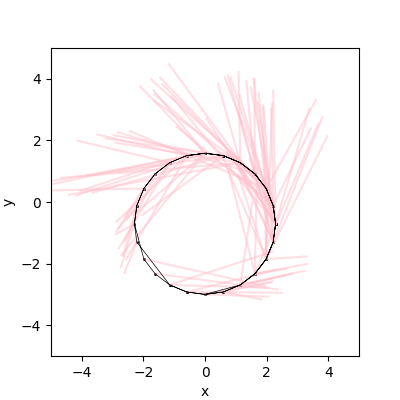

In [4]:
hat_x, zlist = read_data()
draw(hat_x, zlist)

In [27]:
class ObsEdge:
    def __init__(self, t1, t2, z1, z2, xs, sensor_noise_rate=[0.14, 0.05, 0.05]):
        assert z1[0] == z2[0]
        self.t1, self.t2 = t1, t2
        self.x1, self.x2 = xs[t1], xs[t2]
        self.z1, self.z2 = z1[1], z2[1]
        
        s1 = math.sin(self.x1[2] + self.z1[1])
        c1 = math.cos(self.x1[2] + self.z1[1])
        s2 = math.sin(self.x2[2] + self.z2[1])
        c2 = math.cos(self.x2[2] + self.z2[1])
        
        hat_e = self.x2 - self.x1 + np.array([
            self.z2[0] * c2 - self.z1[0] * c1,
            self.z2[0] * s2 - self.z1[0] * s1,
            self.z2[1] - self.z2[2] - self.z1[1] + self.z1[2]
        ])
        while hat_e[2] >= math.pi:
            hat_e[2] -= math.pi * 2
        while hat_e[2] < -math.pi:
            hat_e[2] += math.pi * 2
            
        Q1 = np.diag([(self.z1[0] * sensor_noise_rate[0]) ** 2, sensor_noise_rate[1] ** 2, sensor_noise_rate[2] ** 2])
        R1 = -np.array([[c1, -self.z1[0] * s1, 0],
                                 [s1, self.z1[0] * c1, 0],
                                 [0,                       1, -1]])
        
        Q2 = np.diag([(self.z2[0] * sensor_noise_rate[0]) ** 2, sensor_noise_rate[1] ** 2, sensor_noise_rate[2] ** 2])
        R2 = np.array([[c2, -self.z2[0] * s2, 0],
                                 [s2, self.z2[0] * c2, 0],
                                 [0,                       1, -1]])
        
        Sigma = R1.dot(Q1).dot(R1.T) + R2.dot(Q2).dot(R2.T)
        Omega = np.linalg.inv(Sigma)
        
        B1 = -np.array([[1, 0, -self.z1[0] * s1],
                                 [0, 1, self.z1[0] * c1],
                                 [0, 0,                      1]])
        B2 = np.array([[1, 0, -self.z2[0] * s2],
                                 [0, 1, self.z2[0] * c2],
                                 [0, 0,                     1]])
        
        self.omega_upperleft = B1.T.dot(Omega).dot(B1)
        self.omega_upperright = B1.T.dot(Omega).dot(B2)
        self.omega_bottomleft = B2.T.dot(Omega).dot(B1)
        self.omega_bottomright = B2.T.dot(Omega).dot(B2)
        
        self.xi_upper = -B1.T.dot(Omega).dot(hat_e)
        self.xi_bottom = -B2.T.dot(Omega).dot(hat_e)

In [28]:
import itertools

def make_edges(hat_xs, zlist):
    landmark_keys_zlist = {}
    
    for step in zlist:
        for z in zlist[step]:
            landmark_id = z[0]
            if landmark_id not in landmark_keys_zlist:
                landmark_keys_zlist[landmark_id] = []
            
            landmark_keys_zlist[landmark_id].append((step, z))
    
    edges = []
    for landmark_id in landmark_keys_zlist:
        step_pairs = list(itertools.combinations(landmark_keys_zlist[landmark_id], 2))
        edges += [ObsEdge(xz1[0], xz2[0], xz1[1], xz2[1], hat_xs) for xz1, xz2 in step_pairs]
    
    return edges

def draw_edges(edges, ax):
    for e in edges:
        ax.plot([e.x1[0], e.x2[0]], [e.x1[1], e.x2[1]], color='red', alpha=0.5)
        
def draw(xs, zlist, edges):
    ax = make_ax()
    draw_observations(xs, zlist, ax)
    draw_edges(edges, ax)
    draw_trajectory(xs, ax)
    plt.show()

<IPython.core.display.Javascript object>


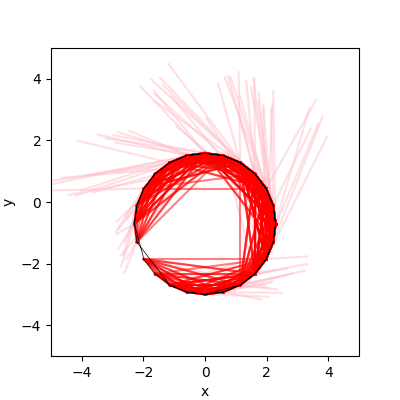

In [29]:
hat_xs, zlist = read_data()
edges = make_edges(hat_xs, zlist)
draw(hat_xs, zlist, edges)

In [30]:
def add_edge(edge, Omega, xi):
    f1, f2 = edge.t1 * 3, edge.t2 * 3
    t1, t2 = f1 + 3, f2 + 3
    Omega[f1:t1, f1:t1] += edge.omega_upperleft
    Omega[f1:t1, f2:t2] += edge.omega_upperright
    Omega[f2:t2, f1:t1] += edge.omega_bottomleft
    Omega[f2:t2, f2:t2] += edge.omega_bottomright
    xi[f1:t1] += edge.xi_upper
    xi[f2:t2] += edge.xi_bottom

1: 8.022261836562025
2: 2.42011469578869
3: 1.223652883695281
4: 0.7990770187847848
5: 0.5267034036525956
6: 0.34887157925182394
7: 0.2318962685034899
8: 0.15462045697991084
9: 0.10343540794945334
10: 0.06947564391198993
11: 0.04692090167507644
12: 0.03193166385730938
13: 0.021967359163339948
14: 0.015343651809324602
15: 0.010942418536807979
16: 0.00802062089761366


<IPython.core.display.Javascript object>


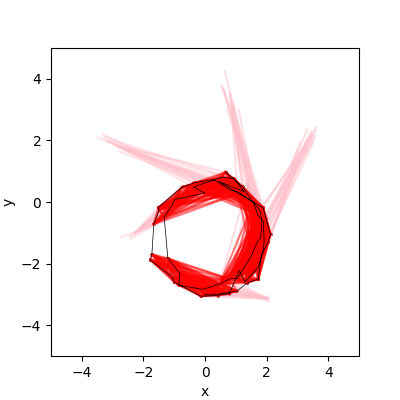

In [31]:
hat_xs, zlist = read_data()
dim = len(hat_xs) * 3

for n in range(1, 10000):
    edges = make_edges(hat_xs, zlist)
    Omega = np.zeros((dim, dim))
    xi = np.zeros(dim)
    Omega[0:3, 0:3] += np.eye(3) * 1000000
    
    for e in edges:
        add_edge(e, Omega, xi)
    
    delta_xs = np.linalg.inv(Omega).dot(xi)
    
    for i in range(len(hat_xs)):
        hat_xs[i] += delta_xs[i *3:(i + 1) * 3]
        
    diff = np.linalg.norm(delta_xs)
    print('{}: {}'.format(n, diff))
    if diff < 0.01:
        draw(hat_xs, zlist, edges)
        break